In this notebook, I train a transformer model on the news-commentary-v16 dataset. The main purpose of this notebook is to study how the performance of the model changes as training set size increases. The result is shown in the plots at the end of this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/ML/Transformers
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ML/Transformers
 Annotated_Transformer_English_to_Chinese_Translator.py
'Copy of Transformer_Chinese_To_English_Translation_v4_scaling_dataset_size.ipynb'
 data
 data.json
 data.pkl
'Encoder_decoder_transformer (1).ipynb'
 Encoder_decoder_transformer1.ipynb
 Encoder_decoder_transformer.ipynb
 EncoderOnlyTransformer
 Encoder_only_transformer_AG_News.ipynb
 Encoder_only_transformer_ArXiv.ipynb
'Encoder_only Transformer_MovieReviews_2.ipynb'
'Encoder_only Transformer_MovieReviews.ipynb'
 Encoder_only_transformer_Prime.ipynb
 Encoder_only_transformer_v2.ipynb
'Encoder_only_transformer_v3 copy.ipynb'
 en.model
'en_sp_model 2.model'
'en_sp_model 2.vocab'
 en_sp_model.model
 en_sp_model.vocab
 en_to_zh_model.pt
 en.vocab
 FullTransformerModel.py
 main.py
 m.model
 models
 m.vocab
 newsdata
 __pycache__
 results_model_size_34155312.txt
 result

In [2]:
!pip install sentencepiece --quiet
!pip install sacrebleu --quiet
!pip install torchinfo

In [3]:
import math
from dataclasses import dataclass

import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import json
import matplotlib.pyplot as plt
from torchinfo import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
SRC = "zh"
TRG = "en"
en_vocab_size = 30000
zh_vocab_size = 30000
vocab_sizes = {"en": en_vocab_size, "zh": zh_vocab_size}
max_seq_len = 50

# Get English and Chinese tokenizers

I use [SentencePiece](https://github.com/google/sentencepiece) to get both the Chinese and English tokenizers. 

The news-commentary-v16 dataset can be downloaded from https://data.statmt.org/news-commentary/v16/training/.

The validation set and test set I used are simply sampled from the news-commentary-v16 dataset, both with a size of 5000.


In [5]:
full_set = pandas.read_csv('data/news-commentary-v16.en-zh.tsv',
                           sep='\t', header=None)
full_set = [(full_set[0][i], full_set[1][i]) for i in range(len(full_set[0]))
          if not isinstance(full_set[0][i], float) and not isinstance(full_set[1][i], float)]
random.shuffle(full_set)
# Note that some translations are really bad, and somehow news-commentary-v16 seems to 
# be one of the popular (small) training set...
full_train_set, valid_set, test_set= torch.utils.data.random_split(
                                        full_set, [len(full_set)-10000, 5000, 5000],
                                        generator=torch.Generator().manual_seed(42))
print(len(full_train_set), len(valid_set), len(test_set))
for i in range(3):
    print(full_train_set[i])

303674 5000 5000
('Unfortunately, the outcome could be similar: the entire banking system sent into a tailspin.', '不幸的是结果可能重蹈覆辙： 整个银行系统可能因此陷入一片狼藉。')
('First, “genetic engineering cannot solve the hunger and food insecurity problem.”', '想一想汽车的发明就造成了多少轮下冤魂，更不用说各种药物的副作用了。')
('Indeed, the time is ripe to offer assurances to the isolated Syrian regime that blocking Hezbollah’s rearmament, stopping Islamist fighters’ passage into Iraq, and improving the country’s appalling human rights record would bring valuable diplomatic and economic benefits, including a strengthened association agreement with the EU.', '的确，给备受孤立的叙利亚政权一些安慰的时机已经成熟。 要让其明白封锁真主党的军备，阻止伊斯兰好战分子进入伊拉克并改善自身触目惊心的人权记录会给它带来外交和经济上的实惠，其中包括强化与欧盟的联合协定。')


In [6]:
def get_tokenizers(dataset, train_set_size):
    en_file = f'data/zh-en_corpus_en_trainsize_{train_set_size}.txt'
    zh_file = f'data/zh-en_corpus_zh_trainsize_{train_set_size}.txt'
    en_sp_model = f'zh-en_en_trainsize_{train_set_size}'
    zh_sp_model = f'zh-en_zh_trainsize_{train_set_size}'
    f_en = open(en_file, "w")
    f_zh = open(zh_file, "w")
    for pair in list(dataset)[0:train_set_size]:
        f_en.write(pair[0] + '\n')
        f_zh.write(pair[1] + '\n')
    f_en.close()
    f_zh.close()
    # train sentencepiece models to get tokenizers
    spm.SentencePieceTrainer.train\
        (f'--input={en_file} --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size={en_vocab_size}')
    spm.SentencePieceTrainer.train\
        (f'--input={zh_file} --model_prefix=zh_sp_model --user_defined_symbols=<pad> --vocab_size={zh_vocab_size}')

    # make SentencePieceProcessor instances and load the model files
    en_sp = spm.SentencePieceProcessor()
    en_sp.load(f'en_sp_model.model')
    zh_sp = spm.SentencePieceProcessor()
    zh_sp.load(f'zh_sp_model.model')

    tokenizers = {"en": en_sp.encode_as_ids, "zh": zh_sp.encode_as_ids}
    detokenizers = {"en":en_sp.decode_ids, "zh":zh_sp.decode_ids}
    id_to_pieces = {"en":en_sp.id_to_piece, "zh":zh_sp.id_to_piece}
    return tokenizers, detokenizers, id_to_pieces

In [7]:
tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, 50000)
print(tokenizers['zh']('这是一个测试。'))
print(tokenizers['en']('This is a test.'))
print([id_to_pieces['zh'](id) for id in range(20)])
print([id_to_pieces['en'](id) for id in range(20)])

[4352, 2036, 5]
[90, 14, 10, 1551, 6]
['<unk>', '<s>', '</s>', '<pad>', ',', '。', '▁', '的', '▁—', '和', '、', '在', '(', '是', '“', ')', '了', '对', '年', '而']
['<unk>', '<s>', '</s>', '<pad>', ',', '▁the', '.', '▁to', '▁of', '▁and', '▁a', '▁in', 's', '▁that', '▁is', '-', '’', '▁', '▁for', '▁–']


In [8]:
# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3

# Data processing

In [9]:
def tokenize_dataset(dataset):
    'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
    if SRC == "zh":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]


In [10]:
class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded


In [11]:
batch_size = 128

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self, train_set_size):
        train_set = list(full_train_set)[0:train_set_size]
        train_dataset = TranslationDataset(tokenize_dataset(train_set))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)


# Transformer Model

In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
  '''residual connection: x + dropout(sublayer(layernorm(x))) '''
  def __init__(self, dim, dropout):
      super().__init__()
      self.drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(dim)

  def forward(self, x, sublayer):
      return x + self.drop(sublayer(self.norm(x)))

# I simply let the model learn the positional embeddings in this notebook, since this 
# almost produces identital results as using sin/cosin functions embeddings, as claimed
# in the original transformer paper. Note also that in the original paper, they multiplied 
# the token embeddings by a factor of sqrt(d_embed), which I do not do here. 

class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [13]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

# Training and evaluation helper functions

In [14]:
def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [15]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses, acc, count = [], 0, 0
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y)  in  pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        # report progress
        if idx>0 and idx%50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}, lr={scheduler.get_last_lr()[0]:.5f}')
    return np.mean(losses)


def train(model, dataloaders, epochs = 10):
    global early_stop_count
    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader)*batch_size
    for ep in range(epochs):
        train_loss = train_epoch(model, dataloaders)
        valid_loss = validate(model, dataloaders.valid_loader)

        print(f'ep: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
        else:
            if scheduler.last_epoch>1.5*warmup_steps:
                early_stop_count -= 1
                if early_stop_count<=0:
                    return train_loss, valid_loss
    return train_loss, valid_loss


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

In [16]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

In [17]:
def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

# Training

In [18]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=512,
                     d_ff=2048,
                     h=8,
                     N_encoder=6,
                     N_decoder=6,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )
results = {}
for train_size in  np.array([5, 10, 15, 20, 25, 30])*10000:
    tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, train_size)
    data_loaders = Dataloaders(train_size)
    model = make_model(config)
    model_size = sum([p.numel() for p in model.parameters()])
    print(f'model_size: {model_size}, train_set_size: {train_size}')
    warmup_steps = 4*len(data_loaders.train_loader)
    # lr first increases in the warmup steps, and then descreases
    lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])
    optimizer = torch.optim.Adam(model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    early_stop_count = 2
    train_loss, valid_loss = train(model, data_loaders, epochs=30)
    test_loss  = validate(model, data_loaders.test_loader)

    print("train set examples:")
    train_bleu = evaluate(model, data_loaders.train_loader, 20)
    print("validation set examples:")
    valid_bleu = evaluate(model, data_loaders.valid_loader)
    print("test set examples:")
    test_bleu  = evaluate(model, data_loaders.test_loader)
    results[f'model_size={model_size}, train_size={train_size}'] = {
                                        'train_loss': train_loss,
                                        'valid_loss': valid_loss,
                                        'test_loss' : test_loss,
                                        'train_bleu': train_bleu,
                                        'valid_bleu': valid_bleu,
                                        'test_bleu': test_bleu}
    f = open('results_news-commentary-v16_only.json', 'w')
    json.dump(results, f)
    f.close()
    torch.save(model, f'saved_models_news-commentary-v16_only/{SRC}_to_{TRG}_dataset_size_{train_size}_model_size_{model_size}.pt')
    print(f'train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f} train_bleu: {train_bleu:.4f}')

model_size: 90301744, train_set_size: 50000


train loss=5.803, lr=0.00025: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 0: train_loss=7.16572, valid_loss=5.70710


train loss=4.925, lr=0.00053: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 1: train_loss=5.28044, valid_loss=4.96857


train loss=4.586, lr=0.00081: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 2: train_loss=4.61512, valid_loss=4.56164


train loss=4.222, lr=0.00109: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 3: train_loss=4.13859, valid_loss=4.31094


train loss=3.724, lr=0.00101: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]


ep: 4: train_loss=3.70600, valid_loss=4.03408


train loss=3.425, lr=0.00092: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 5: train_loss=3.23047, valid_loss=3.84232


train loss=2.776, lr=0.00085: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 6: train_loss=2.81466, valid_loss=3.75483


train loss=2.572, lr=0.00080: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 7: train_loss=2.44972, valid_loss=3.72455


train loss=2.179, lr=0.00075: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 8: train_loss=2.12793, valid_loss=3.76023


train loss=1.872, lr=0.00071: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


ep: 9: train_loss=1.84212, valid_loss=3.83727
train set examples:
src:  为改革进程融资 — — 更不要说筹集高达2万亿规模的公共投资资金以支持后石油时期经济 — — 将需要提高工作效率、实现快速私有化、建立有效的公私伙伴关系、采纳基础广泛的税收制度(包括将于2018年开始实行的5%
trg:  Financing the reforms – not to mention a massive $2 trillion public investment fund to support a post-oil economy – will require improved efficiency, rapid privatization, effective public-private partnerships, broad-based taxation (including a value-added tax
pred: To establish such a program – not to mention a $1 trillion investment fund the economy’s economy – will require rapid public investment, increase efficiency, and establish basic public-private partnerships (by accompanied rapid institutional reform, creating effective public-
src:  在职业女性这一方面,日本就好像是发达国家中的沙特阿拉伯。
trg:  For women in the workplace, Japan remains the Saudi Arabia of the developed world.
pred: In this sense, women are seeking to do so in the developed world, as if Saudi Arabia is Saudi Arabia.
src:  这相当于亲西方势力在中东地区获胜。
trg:  This would 

train loss=5.549, lr=0.00019: 100%|██████████| 782/782 [05:48<00:00,  2.25it/s]


ep: 0: train_loss=6.88474, valid_loss=5.45820


train loss=4.645, lr=0.00039: 100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


ep: 1: train_loss=4.95905, valid_loss=4.47964


train loss=3.878, lr=0.00059: 100%|██████████| 782/782 [05:47<00:00,  2.25it/s]


ep: 2: train_loss=4.09503, valid_loss=3.83931


train loss=3.285, lr=0.00078: 100%|██████████| 782/782 [05:48<00:00,  2.25it/s]


ep: 3: train_loss=3.45347, valid_loss=3.41427


train loss=2.809, lr=0.00071: 100%|██████████| 782/782 [05:49<00:00,  2.24it/s]


ep: 4: train_loss=2.96044, valid_loss=3.03198


train loss=2.541, lr=0.00065: 100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


ep: 5: train_loss=2.53580, valid_loss=2.84268


train loss=2.181, lr=0.00060: 100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


ep: 6: train_loss=2.21805, valid_loss=2.74874


train loss=1.983, lr=0.00056: 100%|██████████| 782/782 [05:48<00:00,  2.25it/s]


ep: 7: train_loss=1.96270, valid_loss=2.71522


train loss=1.839, lr=0.00053: 100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


ep: 8: train_loss=1.74683, valid_loss=2.74545


train loss=1.652, lr=0.00050: 100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


ep: 9: train_loss=1.56001, valid_loss=2.74348
train set examples:
src:  它可能是一个例外,反映了各种因素,包括欧元危机、欧洲国家经济持续萎靡、大宗商品价格暴跌、巴西、俄罗斯和其他新兴经济体大幅放缓、国际银行监管收紧(可能拖累贸易融资)等。
trg:  It may have been a singular occurrence that reflected a variety of factors, including the euro crisis; continued economic weakness in many European countries; the sharp decline in commodity prices; dramatic slowdowns in Brazil, Russia, and other emerging economies; and
pred: It may be a case in which different factors, including the euro crisis, continued economic weakness in Europe, continued commodity prices, a sharp slowdown in Brazil, Russia, and other emerging economies, tighter controls (which may be possible to be
src:  中等收入的非经合组织国家 — — 尤其是中国和印度 — — 正逐渐成为高技术劳动力越来越重要的目标国。
trg:  Middle-income non-OECD countries – particularly China and India – are becoming an increasingly important destination for high-skilled labor.
pred: Non-income countries – especially China and India – are gradually becoming a high-tech labor force.


train loss=5.371, lr=0.00016: 100%|██████████| 1172/1172 [08:43<00:00,  2.24it/s]


ep: 0: train_loss=6.71223, valid_loss=5.30126


train loss=4.325, lr=0.00032: 100%|██████████| 1172/1172 [08:43<00:00,  2.24it/s]


ep: 1: train_loss=4.74675, valid_loss=4.16335


train loss=3.442, lr=0.00048: 100%|██████████| 1172/1172 [08:43<00:00,  2.24it/s]


ep: 2: train_loss=3.73672, valid_loss=3.37008


train loss=3.027, lr=0.00064: 100%|██████████| 1172/1172 [08:43<00:00,  2.24it/s]


ep: 3: train_loss=3.08052, valid_loss=2.95855


train loss=2.695, lr=0.00058: 100%|██████████| 1172/1172 [08:42<00:00,  2.24it/s]


ep: 4: train_loss=2.65891, valid_loss=2.64468


train loss=2.283, lr=0.00053: 100%|██████████| 1172/1172 [08:43<00:00,  2.24it/s]


ep: 5: train_loss=2.31216, valid_loss=2.49785


train loss=2.075, lr=0.00049: 100%|██████████| 1172/1172 [08:42<00:00,  2.24it/s]


ep: 6: train_loss=2.05969, valid_loss=2.43421


train loss=2.006, lr=0.00046: 100%|██████████| 1172/1172 [08:41<00:00,  2.25it/s]


ep: 7: train_loss=1.86149, valid_loss=2.35552


train loss=1.883, lr=0.00043: 100%|██████████| 1172/1172 [08:41<00:00,  2.25it/s]


ep: 8: train_loss=1.69569, valid_loss=2.35692


train loss=1.531, lr=0.00041: 100%|██████████| 1172/1172 [08:41<00:00,  2.25it/s]


ep: 9: train_loss=1.55302, valid_loss=2.37370
train set examples:
src:  这种约定俗成的责任意识就可以解释为什么哈米德·卡尔扎伊总统的那么多亲信依然在位,也可以解释塔利班领导人为什么仍然安全。
trg:  This sense of customary obligation is why so many of President Hamid Karzai’s cronies remain in place and Taliban leaders remain safe.
pred: This sense of accountability can explain why so many cronies of President Hamid Karzai remain in office, and why Taliban leaders continue to be safe.
src:  如果政客们热衷于互相指责的话,就更加难上加难了。
trg:  It becomes harder still when politicians are actively playing the blame game.
pred: If politicians are to blame each other, it becomes even harder to do so.
src:  而这个情况之所以没有在希腊身上发生就是因为希腊被单一货币捆住了手脚。
trg:  It hasn’t happened in Greece only because Greece is trapped in the single currency.
pred: This is not what happened in Greece because Greece is trapped by the single currency.
validation set examples:
src:  无论如何,巴勒斯坦人中间的分歧绝非此次谈判失败的原因。
trg:  Regardless, the division among Palestinians cannot be blamed for the talks’ failure this 

train loss=5.110, lr=0.00014: 100%|██████████| 1563/1563 [11:34<00:00,  2.25it/s]


ep: 0: train_loss=6.60322, valid_loss=5.19853


train loss=3.986, lr=0.00028: 100%|██████████| 1563/1563 [11:34<00:00,  2.25it/s]


ep: 1: train_loss=4.57244, valid_loss=3.92268


train loss=3.220, lr=0.00042: 100%|██████████| 1563/1563 [11:34<00:00,  2.25it/s]


ep: 2: train_loss=3.48024, valid_loss=3.07887


train loss=2.932, lr=0.00056: 100%|██████████| 1563/1563 [11:33<00:00,  2.25it/s]


ep: 3: train_loss=2.85324, valid_loss=2.75454


train loss=2.387, lr=0.00050: 100%|██████████| 1563/1563 [11:33<00:00,  2.25it/s]


ep: 4: train_loss=2.47821, valid_loss=2.44443


train loss=2.167, lr=0.00046: 100%|██████████| 1563/1563 [11:34<00:00,  2.25it/s]


ep: 5: train_loss=2.17633, valid_loss=2.32082


train loss=2.120, lr=0.00042: 100%|██████████| 1563/1563 [11:35<00:00,  2.25it/s]


ep: 6: train_loss=1.96161, valid_loss=2.24451


train loss=1.921, lr=0.00040: 100%|██████████| 1563/1563 [11:34<00:00,  2.25it/s]


ep: 7: train_loss=1.79288, valid_loss=2.21627


train loss=1.700, lr=0.00037: 100%|██████████| 1563/1563 [11:33<00:00,  2.25it/s]


ep: 8: train_loss=1.65366, valid_loss=2.20177


train loss=1.642, lr=0.00035: 100%|██████████| 1563/1563 [11:33<00:00,  2.26it/s]


ep: 9: train_loss=1.53369, valid_loss=2.19280


train loss=1.495, lr=0.00034: 100%|██████████| 1563/1563 [11:33<00:00,  2.26it/s]


ep: 10: train_loss=1.42787, valid_loss=2.23528


train loss=1.379, lr=0.00032: 100%|██████████| 1563/1563 [11:34<00:00,  2.25it/s]


ep: 11: train_loss=1.33488, valid_loss=2.22834
train set examples:
src:  鉴于议程所涉及的范畴(我能想到至少有六大主题需要单独谈判 ) , 谈判过程可能需要数年才能完成。
trg:  Given the scope of the agenda (I can think of at least six major topics that will demand their own negotiations), the process could take several years.
pred: Given the scale of the agenda (which I can imagine at least six topics that need to negotiate separately), the process could take years to complete.
src:  你在加沙看到的惊人数量的孩子将会继承一个什么样的世界? 集体惩罚能否将他们变成温和、守法的希洛奴隶?
trg:  What type of world will the children you see in such prodigious numbers in Gaza inherit? Will collective punishment make them moderate, law-abiding helots?
pred: What will happen to the world that one child of the terrible number of children in Gaza will inherit? Will collective punishment make them moderate, law-abiding?
src:  对领导能力的学习有许多种途径,从经验中学习是其中最常见、也是最有力的方式,它带给人们在危机中至关重要的习惯知识。
trg:  Learning leadership occurs in a variety of ways. Learning from experience is the most common and most powerfu

train loss=5.095, lr=0.00012: 100%|██████████| 1954/1954 [14:28<00:00,  2.25it/s]


ep: 0: train_loss=6.51223, valid_loss=5.11890


train loss=3.841, lr=0.00025: 100%|██████████| 1954/1954 [14:30<00:00,  2.24it/s]


ep: 1: train_loss=4.43651, valid_loss=3.70764


train loss=2.984, lr=0.00037: 100%|██████████| 1954/1954 [14:28<00:00,  2.25it/s]


ep: 2: train_loss=3.28879, valid_loss=2.91204


train loss=2.649, lr=0.00050: 100%|██████████| 1954/1954 [14:29<00:00,  2.25it/s]


ep: 3: train_loss=2.70645, valid_loss=2.57289


train loss=2.453, lr=0.00045: 100%|██████████| 1954/1954 [14:30<00:00,  2.24it/s]


ep: 4: train_loss=2.37184, valid_loss=2.32862


train loss=2.026, lr=0.00041: 100%|██████████| 1954/1954 [14:30<00:00,  2.24it/s]


ep: 5: train_loss=2.10098, valid_loss=2.20752


train loss=1.874, lr=0.00038: 100%|██████████| 1954/1954 [14:30<00:00,  2.25it/s]


ep: 6: train_loss=1.91169, valid_loss=2.14728


train loss=1.857, lr=0.00035: 100%|██████████| 1954/1954 [14:30<00:00,  2.25it/s]


ep: 7: train_loss=1.76378, valid_loss=2.12538


train loss=1.874, lr=0.00033: 100%|██████████| 1954/1954 [14:30<00:00,  2.24it/s]


ep: 8: train_loss=1.64139, valid_loss=2.09337


train loss=1.675, lr=0.00032: 100%|██████████| 1954/1954 [14:29<00:00,  2.25it/s]


ep: 9: train_loss=1.53845, valid_loss=2.06323


train loss=1.487, lr=0.00030: 100%|██████████| 1954/1954 [14:28<00:00,  2.25it/s]


ep: 10: train_loss=1.44684, valid_loss=2.09922


train loss=1.449, lr=0.00029: 100%|██████████| 1954/1954 [14:27<00:00,  2.25it/s]


ep: 11: train_loss=1.36696, valid_loss=2.11025
train set examples:
src:  因此,20世纪90年代初英镑和里拉贬值后,法国和德国受到了消极的贸易冲击,人们从中汲取的教训是需要单一货币来防止这类不同冲击再次发生。
trg:  Thus, in the aftermath of the sterling and lira devaluations of the early 1990’s, with their resulting adverse trade shocks to France and Germany, the lesson that was drawn was that a single currency was needed to prevent such disparate shocks from recurring
pred: So, since the fall of the pound and the lira in the early 1990’s, France and Germany were hit by negative trade shocks, and the lesson that the single currency needed to prevent such disparate shocks is to prevent such a scenario.
src:  此外,由于相近物种间的杂交是普遍现象,有可能对一种蚊子的修改会逐步地、不可控地扩大到其他物种。
trg:  Moreover, given the ubiquity of hybridization among neighboring species, it is possible that the modification of a mosquito species would also spread progressively and uncontrollably to other species.
pred: Moreover, because the hybridization among neighboring species is common, it threatens to e

train loss=5.104, lr=0.00011: 100%|██████████| 2344/2344 [17:19<00:00,  2.25it/s]


ep: 0: train_loss=6.43990, valid_loss=5.02557


train loss=3.593, lr=0.00023: 100%|██████████| 2344/2344 [17:21<00:00,  2.25it/s]


ep: 1: train_loss=4.29827, valid_loss=3.51074


train loss=2.828, lr=0.00034: 100%|██████████| 2344/2344 [17:21<00:00,  2.25it/s]


ep: 2: train_loss=3.11869, valid_loss=2.74352


train loss=2.586, lr=0.00045: 100%|██████████| 2344/2344 [17:21<00:00,  2.25it/s]


ep: 3: train_loss=2.58255, valid_loss=2.43550


train loss=2.140, lr=0.00041: 100%|██████████| 2344/2344 [17:20<00:00,  2.25it/s]


ep: 4: train_loss=2.27976, valid_loss=2.22763


train loss=1.994, lr=0.00037: 100%|██████████| 2344/2344 [17:20<00:00,  2.25it/s]


ep: 5: train_loss=2.03613, valid_loss=2.10520


train loss=1.876, lr=0.00035: 100%|██████████| 2344/2344 [17:18<00:00,  2.26it/s]


ep: 6: train_loss=1.86511, valid_loss=2.07317


train loss=1.736, lr=0.00032: 100%|██████████| 2344/2344 [17:21<00:00,  2.25it/s]


ep: 7: train_loss=1.73330, valid_loss=2.00812


train loss=1.682, lr=0.00030: 100%|██████████| 2344/2344 [17:21<00:00,  2.25it/s]


ep: 8: train_loss=1.62570, valid_loss=1.98915


train loss=1.588, lr=0.00029: 100%|██████████| 2344/2344 [17:19<00:00,  2.25it/s]


ep: 9: train_loss=1.53431, valid_loss=2.00509


train loss=1.535, lr=0.00028: 100%|██████████| 2344/2344 [17:21<00:00,  2.25it/s]


ep: 10: train_loss=1.45357, valid_loss=1.99438
train set examples:
src:  与此同时,各国民众将对方视作不值得信赖的敌人的做法必须停止。
trg:  At the same time, people worldwide must stop regarding one another as untrustworthy enemies.
pred: At the same time, it must stop national citizens from viewing the other as a trusted enemy.
src:  所有这些,用梅不会用的话说,感觉就好像是一场非常不友好的离婚。
trg:  All of this, to return to the word May won’t use, feels like a rather unamicable divorce.
pred: All of this, in May’s words, feels like a very bad divorce.
src:  中国问题足以让世界经济和股市在这个十年的剩余几年中一蹶不振。
trg:  China is surely a big enough problem to throw the world economy and equity markets off the rails for the rest of this decade.
pred: China’s problems are enough to perpetuate the world economy and equity markets in the rest of the decade.
validation set examples:
src:  但我们必须采取措施避免发生最坏情况,而不是沉迷于宿命论。
trg:  But, rather than wallow in fatalism, we must take steps to avert the worst.
pred: But we must take steps to avoid the worst, not relying on fatalism.
sr

In [20]:
summary(model)

Layer (type:depth-idx)                                  Param #
Transformer                                             --
├─Encoder: 1-1                                          --
│    └─Embedding: 2-1                                   15,360,000
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderBlock: 3-1                           3,152,384
│    │    └─EncoderBlock: 3-2                           3,152,384
│    │    └─EncoderBlock: 3-3                           3,152,384
│    │    └─EncoderBlock: 3-4                           3,152,384
│    │    └─EncoderBlock: 3-5                           3,152,384
│    │    └─EncoderBlock: 3-6                           3,152,384
│    └─Dropout: 2-3                                     --
│    └─LayerNorm: 2-4                                   1,024
├─Decoder: 1-2                                          --
│    └─Embedding: 2-5                                   15,360,000
│    └─Dropout: 2-6                              

# Scaling and extrapolation

In [21]:
from scipy.optimize import curve_fit

In [22]:
f = open('results_news-commentary-v16_only.json', 'r')
res = json.load(f)
print(res)

{'model_size=90301744, train_size=50000': {'train_loss': 1.8421159223522372, 'valid_loss': 3.837266540527344, 'test_loss': 3.8280940890312194, 'train_bleu': 19.023623151437462, 'valid_bleu': 8.510183855099791, 'test_bleu': 8.508660093282119}, 'model_size=90301744, train_size=100000': {'train_loss': 1.5600060982167567, 'valid_loss': 2.7434798538684846, 'test_loss': 2.7614079296588896, 'train_bleu': 29.17207959108856, 'valid_bleu': 15.757918281499656, 'test_bleu': 15.93365605634247}, 'model_size=90301744, train_size=150000': {'train_loss': 1.5530199392256883, 'valid_loss': 2.373695957660675, 'test_loss': 2.363886374235153, 'train_bleu': 29.861842815546225, 'valid_bleu': 18.937841110164882, 'test_bleu': 19.11025427731958}, 'model_size=90301744, train_size=200000': {'train_loss': 1.334876204558999, 'valid_loss': 2.2283440828323364, 'test_loss': 2.235159456729889, 'train_bleu': 35.1289746663993, 'valid_bleu': 20.77695943977966, 'test_bleu': 20.8972762873247}, 'model_size=90301744, train_siz

In [23]:
sizes = []
test_losses = []
test_bleus = []

for size in np.array([5, 10, 15, 20, 25, 30])*10000:
    result = res['model_size=90301744, train_size='+str(size)]
    print(f'model_size=90301744, train_size={str(size)}:')
    print(result)
    sizes.append(size)
    test_losses.append(result['test_loss'])
    test_bleus.append(result['test_bleu'])


model_size=90301744, train_size=50000:
{'train_loss': 1.8421159223522372, 'valid_loss': 3.837266540527344, 'test_loss': 3.8280940890312194, 'train_bleu': 19.023623151437462, 'valid_bleu': 8.510183855099791, 'test_bleu': 8.508660093282119}
model_size=90301744, train_size=100000:
{'train_loss': 1.5600060982167567, 'valid_loss': 2.7434798538684846, 'test_loss': 2.7614079296588896, 'train_bleu': 29.17207959108856, 'valid_bleu': 15.757918281499656, 'test_bleu': 15.93365605634247}
model_size=90301744, train_size=150000:
{'train_loss': 1.5530199392256883, 'valid_loss': 2.373695957660675, 'test_loss': 2.363886374235153, 'train_bleu': 29.861842815546225, 'valid_bleu': 18.937841110164882, 'test_bleu': 19.11025427731958}
model_size=90301744, train_size=200000:
{'train_loss': 1.334876204558999, 'valid_loss': 2.2283440828323364, 'test_loss': 2.235159456729889, 'train_bleu': 35.1289746663993, 'valid_bleu': 20.77695943977966, 'test_bleu': 20.8972762873247}
model_size=90301744, train_size=250000:
{'tr

In [24]:
num_tokens = []
for num_sentences in np.array([5, 10, 15, 20, 25, 30])*10000:
    num_tokens.append(sum([len(x[0]) for x in tokenize_dataset(list(full_train_set)[0:num_sentences])]))
sizes = num_tokens

[-0.24270145  4.52026597]
[-2.73705745e+07  2.69088414e+01]


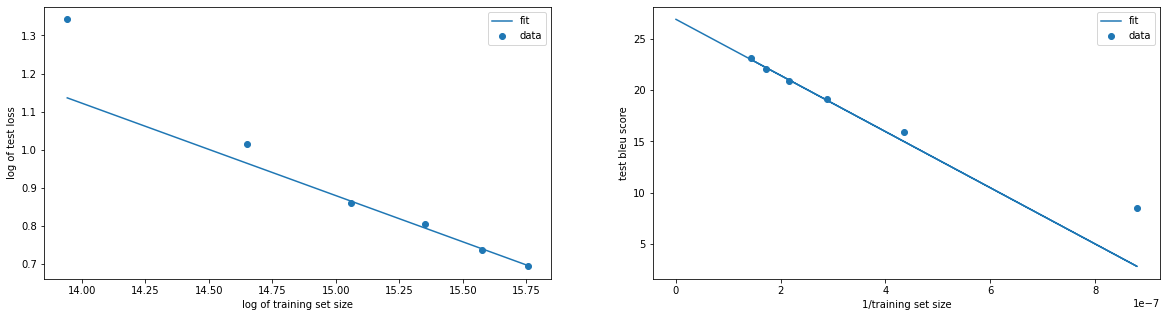

In [25]:
def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(1, 2, figsize=(20,5))

logsize = np.log(sizes)
logloss = np.log(test_losses)
fit_params, _ = curve_fit(linear_fn, logsize[2:], logloss[2:])
print(fit_params)

loss_fitted_data = linear_fn(logsize, fit_params[0], fit_params[1])
ax[0].scatter(logsize, logloss, label='data')
ax[0].plot(logsize, loss_fitted_data, label='fit')
ax[0].set_xlabel('log of training set size')
ax[0].set_ylabel('log of test loss')
ax[0].legend()

oneoversizes = np.reciprocal(np.array(sizes, dtype=float))
fit_params, _ =curve_fit(linear_fn, oneoversizes[2:], test_bleus[2:])
print(fit_params)
bleu_fitted_data = linear_fn(np.insert(oneoversizes, 0, 0, 0), fit_params[0], fit_params[1])

ax[1].plot(np.insert(oneoversizes, 0, 0, 0), bleu_fitted_data, label='fit')
ax[1].scatter(np.reciprocal(np.array(sizes, dtype=float)), test_bleus,  label='data')
ax[1].set_xlabel('1/training set size')
ax[1].set_ylabel('test bleu score')
ax[1].legend()
plt.show()

Training set size in the above plots are defined as the number of tokens in the English sentences in the training set. The fits above are from the last four data points. From the first plot above, the test loss and the training set size kind of follow a power law. And from the second plot, the BLEU score seems to improve as a linear function of 1/train_set_size, and approaches 26.9 as the training set size goes to infinity. But of course, I only have six data points from the range of 50k training examples to 300k training examples, it is hard to say what would happen if I use a much larger training set, and the fits above are not perfect. 